In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from zipfile import ZipFile
file_name='/content/drive/My Drive/Severstal-Steel-Defect-detection.zip'
with ZipFile(file_name,'r') as Zip:
  Zip.extractall()

In [ ]:
import tensorflow as tf
import keras
from PIL import Image
import os
import numpy as np
import tensorflow_addons as tfa
from tqdm import tqdm
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def recall_m(y_true, y_pred):
    print(K.clip(y_true * y_pred, 0, 1))
    print(K.round(K.clip(y_true * y_pred, 0, 1)))
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      
    recall = true_positives / (possible_positives + K.epsilon())   
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def path2image(path):
  image_string = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image_string, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [299,299])
  image=tf.expand_dims(image,0)
  return image

In [ ]:
def seg_pred(path):
    image_string = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float16)
    image = tf.image.resize(image, [256,800])
    image = tf.image.convert_image_dtype(image, tf.uint8)
    image=tf.expand_dims(image,0)
    return image

In [ ]:
dependencies = {
    'precision_m': precision_m,
    'recall_m':recall_m,
    'f1_m':f1_m}

po='/content/drive/My Drive/binary_model/weights-18-0.9643.hdf5'
binary_model=tf.keras.models.load_model(filepath=po, custom_objects=dependencies, compile=True)

In [ ]:
po='/content/drive/My Drive/multi_lab_model/weights-18-0.9193.hdf5'
multilabel_model=tf.keras.models.load_model(filepath=po, compile=True)

In [ ]:
po='/content/drive/My Drive/defect1_seg_model/weights_7.hdf5'
defect1_model=tf.keras.models.load_model(filepath=po)

In [ ]:
po='/content/drive/My Drive/defect2_seg_model/weights_7.hdf5'
defect2_model=tf.keras.models.load_model(filepath=po)

In [ ]:
po='/content/drive/My Drive/defect3_seg_model/weights_10.hdf5'
defect3_model=tf.keras.models.load_model(filepath=po)

In [ ]:
po='/content/drive/My Drive/defect4_seg_model/weights_8.hdf5'
defect4_model=tf.keras.models.load_model(filepath=po)

In [ ]:
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
    
def sum_enc(i):
    return sum([int(k) for k in i.split(' ')[1::2]])

In [ ]:
def rle2mask(mask_rle, shape=(1600,256)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1])
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape).T

In [ ]:
def combine_mask(rles):
    d = len(rles)
    h, w = 256,1600
    mask = np.zeros((h, w, d))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            mask[:, :, i] = rle2mask(rle, (w, h))
    
    return mask

In [ ]:
def mask_predict(location):
  output=[]
  po=os.listdir('test_images')
  for u in tqdm(np.random.randint(0,len(po),10)):
    i=po[u]
    path='test_images/'+i
    img=path2image(path)
    binary_model_pred=binary_model(img)[0][0] 
    if binary_model_pred>=0.45:
      multilabel_model_pred=multilabel_model(img)[0]
      seg_img=seg_pred(path)
      if multilabel_model_pred[0]>=0.8:
        defect1_model_pred=mask2rle(np.array(tf.cast(tf.image.resize(defect1_model(seg_img),(256,1600)),np.uint8)[0,:,:,0]))
        s1=sum_enc(defect1_model_pred)
        if s1>=450 and s1<=17983:
          output.append([i+'_1',defect1_model_pred])
      else:
        output.append([i+'_1',''])
      if multilabel_model_pred[1]>=0.5:
        defect2_model_pred=mask2rle(np.array(tf.cast(tf.image.resize(defect2_model(seg_img),(256,1600)),np.uint8)[0,:,:,0]))
        s2=sum_enc(defect2_model_pred)
        if s2>=700 and s2<=9200:
          output.append([i+'_2',defect2_model_pred])
      else:
        output.append([i+'_2',''])
      if multilabel_model_pred[2]>=0.65:
        defect3_model_pred=mask2rle(np.array(tf.cast(tf.image.resize(defect3_model(seg_img),(256,1600)),np.uint8)[0,:,:,0]))
        s3=sum_enc(defect3_model_pred)
        if s3>=900 and s3<=162877:
          output.append([i+'_3',defect3_model_pred])
      else:
        output.append([i+'_3',''])
      if multilabel_model_pred[3]>=0.35:
        defect4_model_pred=mask2rle(np.array(tf.cast(tf.image.resize(defect4_model(seg_img),(256,1600)),np.uint8)[0,:,:,0]))
        s4=sum_enc(defect4_model_pred)
        if s4>=2200 and s4<=1280000:
          output.append([i+'_4',defect4_model_pred])
      else:
        output.append([i+'_4',''])
    else:
      output.append([i+'_1',''])
      output.append([i+'_2',''])
      output.append([i+'_3',''])
      output.append([i+'_4',''])
  f=pd.DataFrame(output,columns=['ImageId_ClassId','EncodedPixels'])
          
  return f

In [ ]:
out=mask_predict('test_images')

100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


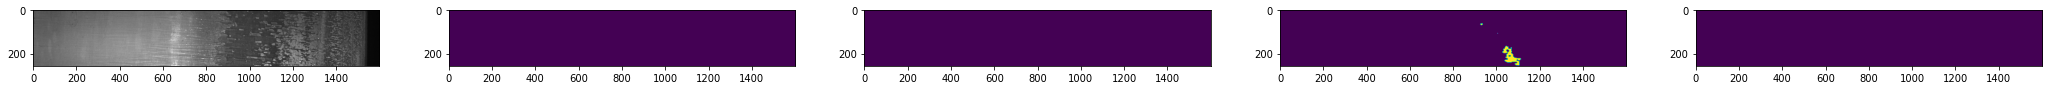

Prediction : Steel has type 3 defect
******************************************************************************************************************************************************************** 



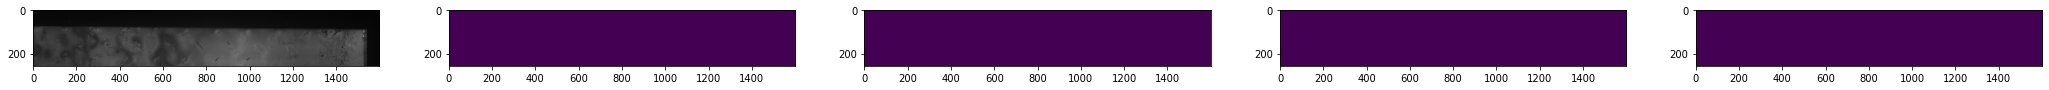

Prediction : Steel has no defect defect
******************************************************************************************************************************************************************** 



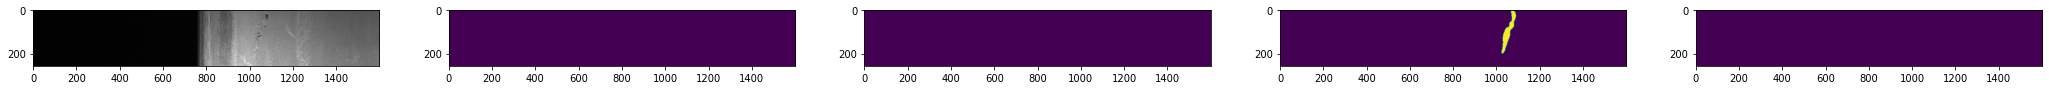

Prediction : Steel has type 3 defect
******************************************************************************************************************************************************************** 



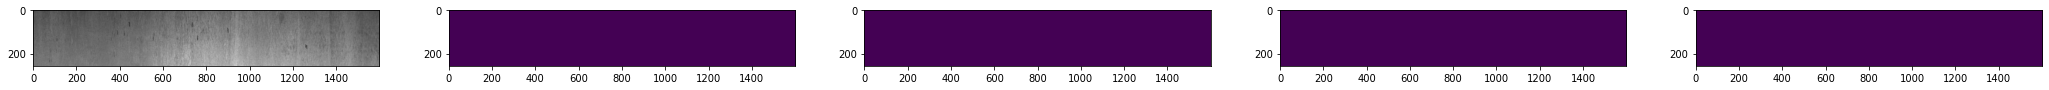

Prediction : Steel has no defect defect
******************************************************************************************************************************************************************** 



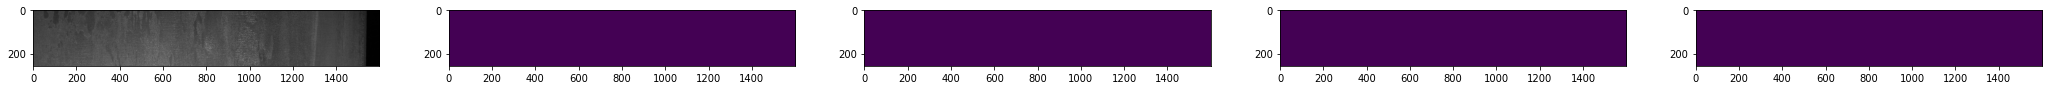

Prediction : Steel has no defect defect
******************************************************************************************************************************************************************** 



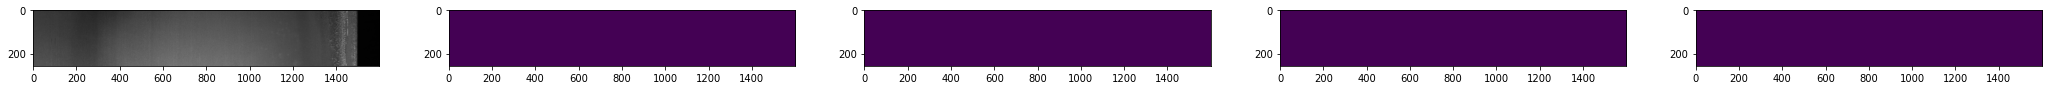

Prediction : Steel has no defect defect
******************************************************************************************************************************************************************** 



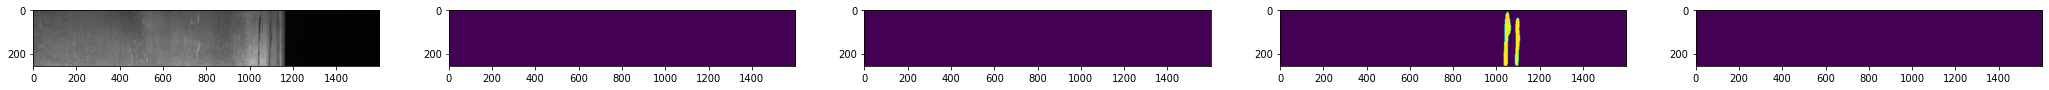

Prediction : Steel has type 3 defect
******************************************************************************************************************************************************************** 



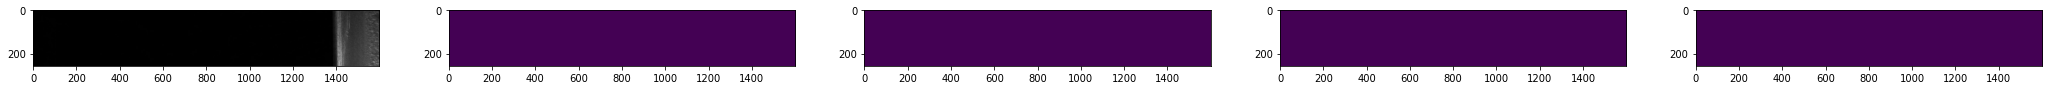

Prediction : Steel has no defect defect
******************************************************************************************************************************************************************** 



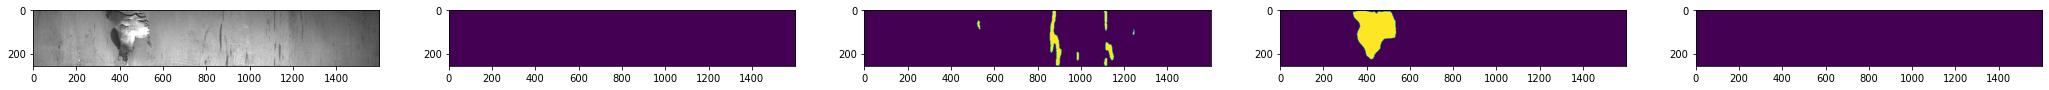

Prediction : Steel has type 2 defect
Prediction : Steel has type 3 defect
******************************************************************************************************************************************************************** 



In [ ]:
s=0
e=4
q=out.EncodedPixels.values
p=out.ImageId_ClassId
for i in range(int(len(out)/4)):
      o='test_images/'+p[s].split('_')[0]
      po=q[s:e]
      t=combine_mask(po)
      s=s+4
      e=e+4
      plt.figure(figsize=(36,26))
      plt.subplot(151)
      plt.imshow(plt.imread(o))
      plt.subplot(152)
      plt.imshow(t[:,:,0])
      plt.subplot(153)
      plt.imshow(t[:,:,1])
      plt.subplot(154)
      plt.imshow(t[:,:,2])
      plt.subplot(155)
      plt.imshow(t[:,:,3])
      plt.show()
      w=len(np.where(t[:,:,0]>0)[0])  
      if w>0:
        print('Prediction : Steel has type 1 defect')
      x=len(np.where(t[:,:,1]>0)[0])
      if x>0:
        print('Prediction : Steel has type 2 defect')
      y=len(np.where(t[:,:,2]>0)[0])
      if y>0:
        print('Prediction : Steel has type 3 defect')
      z=len(np.where(t[:,:,3]>0)[0])
      if z>0:
        print('Prediction : Steel has type 4 defect')
      if (w+x+y+z)==0:
        print('Prediction : Steel has no defect defect')
      print('**'*82,'\n')